In [37]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, random_split, DataLoader
from matplotlib import pyplot as plt


# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create dataset
N = 5000  # Number of samples
x = torch.randn(N, 3)  # 3D Gaussian (normal) distribution
y = x / torch.norm(x, dim=1, keepdim=True)  # Project to unit sphere

# Split data
dataset = TensorDataset(x, y)
train_size = int(0.7 * N)  # 70% train
val_size = int(0.15 * N)  # 15% validation
test_size = N - train_size - val_size  # 15% test

train_data, val_data, test_data = random_split(
    dataset, [train_size, val_size, test_size]
)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [38]:
# Create a unit sphere mesh for visualisation
def create_unit_sphere(radius=1.0, resolution=50):
    """Generate wireframe for a unit sphere"""
    phi = np.linspace(0, np.pi, resolution)  # Vertical angles
    theta = np.linspace(0, 2 * np.pi, resolution)  # Horizontal angles

    # Spherical to Cartesian conversion
    phi_grid, theta_grid = np.meshgrid(phi, theta)
    x = radius * np.sin(phi_grid) * np.cos(theta_grid)
    y = radius * np.sin(phi_grid) * np.sin(theta_grid)
    z = radius * np.cos(phi_grid)

    return x, y, z

# Generate sphere wireframe
sphere_x, sphere_y, sphere_z = create_unit_sphere(radius=1.0)

In [39]:
def include_unit_sphere(ax, unit_sphere=True):
    """Add unit sphere if requested"""
    if unit_sphere:
        ax.plot_wireframe(sphere_x, sphere_y, sphere_z,
                         color='red', alpha=0.2, linewidth=0.5, label='Unit sphere')

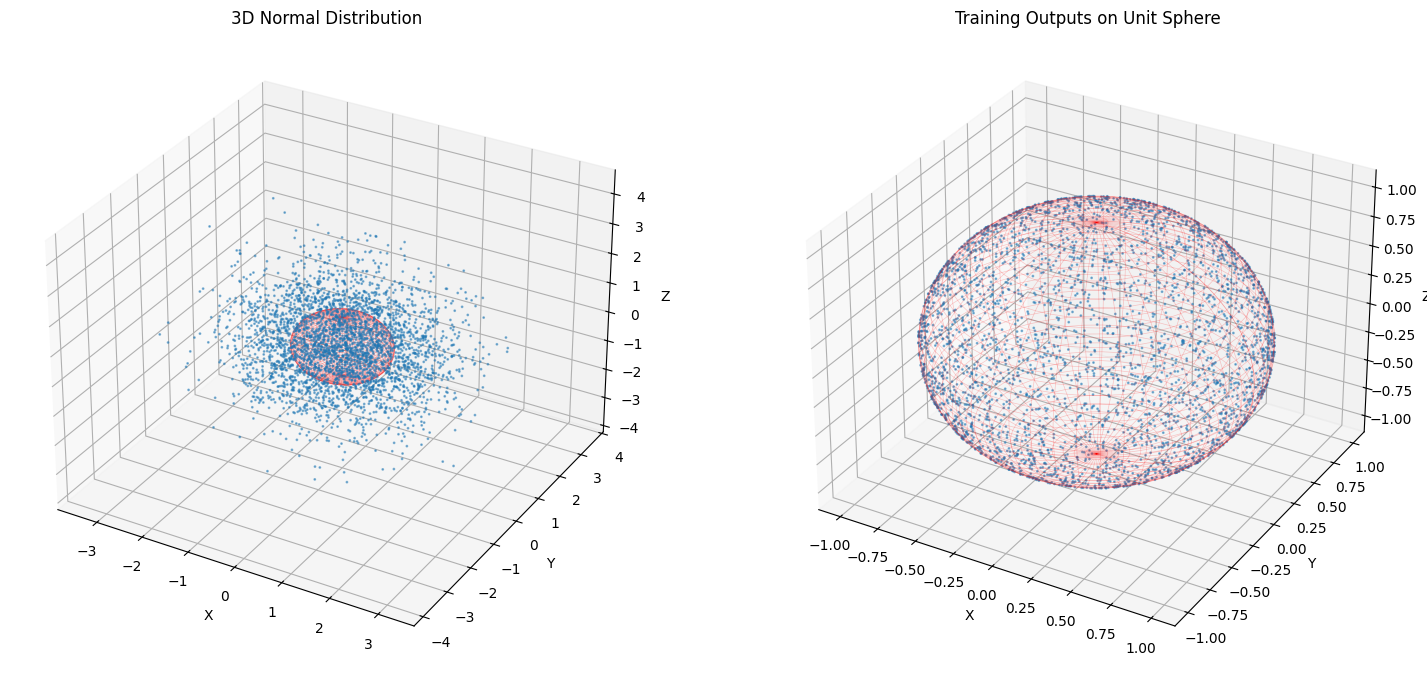

In [40]:
# 3D plot of training targets
fig = plt.figure(figsize=(18, 18))
def plot_sphere(location, data, title, unit_sphere=True):
    """Sphere visualisation"""
    ax = fig.add_subplot(location, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2],
               s=1, alpha=0.5, label='Data points')

    # Add unit sphere if requested
    include_unit_sphere(ax, unit_sphere=unit_sphere)

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# 3D normal distribution (input x)
x = x[train_data.indices]  # Limit display with [:500]
plot_sphere(121, x, "3D Normal Distribution", True)

# Training targets (output y)
y = y[train_data.indices] 
plot_sphere(122, y, "Training Outputs on Unit Sphere", True)

# Display
plt.show()

In [41]:
# Create neural network
class NN(nn.Module):
    """Neural network with leaky ReLU"""
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 20),
            nn.LeakyReLU(0.01),
            nn.Linear(20, 20),
            nn.LeakyReLU(0.01),
            nn.Linear(20, 20),
            nn.LeakyReLU(0.01),
            nn.Linear(20, 3)  # No activation for output layer (linear)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.layers(x)

model = NN()

# Loss and optimiser
criterion = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

# Early stopping setup
best_val_loss = float('inf')
patience = 10
counter = 0
train_losses = []
val_losses = []

In [42]:
# Training with explicit gradients
num_epochs = 200

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    for x_batch, y_batch in train_loader:
        optimiser.zero_grad()  # Reset gradients
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()  # Explicit gradient calculation
        optimiser.step()
        epoch_train_loss += loss.item() * x_batch.size(0)

    # Validation phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            epoch_val_loss += loss.item() * x_val.size(0)

    # Calculate average losses
    epoch_train_loss /= len(train_loader.dataset)
    epoch_val_loss /= len(val_loader.dataset)
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    # Print progress
    if (epoch + 1) % 10 == 0:  # Print every 10 logs
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_train_loss:.6f} | '
              f'Val Loss: {epoch_val_loss:.6f}')

    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

Epoch 10/200 | Train Loss: 0.007741 | Val Loss: 0.007074
Epoch 20/200 | Train Loss: 0.002410 | Val Loss: 0.002233
Epoch 30/200 | Train Loss: 0.001708 | Val Loss: 0.001567
Epoch 40/200 | Train Loss: 0.001409 | Val Loss: 0.001423
Epoch 50/200 | Train Loss: 0.001208 | Val Loss: 0.001150
Epoch 60/200 | Train Loss: 0.001062 | Val Loss: 0.001015
Epoch 70/200 | Train Loss: 0.000968 | Val Loss: 0.000945
Epoch 80/200 | Train Loss: 0.000852 | Val Loss: 0.000778
Epoch 90/200 | Train Loss: 0.000806 | Val Loss: 0.000768
Epoch 100/200 | Train Loss: 0.000746 | Val Loss: 0.000745
Epoch 110/200 | Train Loss: 0.000694 | Val Loss: 0.000688
Epoch 120/200 | Train Loss: 0.000667 | Val Loss: 0.000671
Epoch 130/200 | Train Loss: 0.000642 | Val Loss: 0.000620
Epoch 140/200 | Train Loss: 0.000600 | Val Loss: 0.000598
Epoch 150/200 | Train Loss: 0.000584 | Val Loss: 0.000589
Epoch 160/200 | Train Loss: 0.000575 | Val Loss: 0.000557
Epoch 170/200 | Train Loss: 0.000545 | Val Loss: 0.000543
Early stopping at epoch

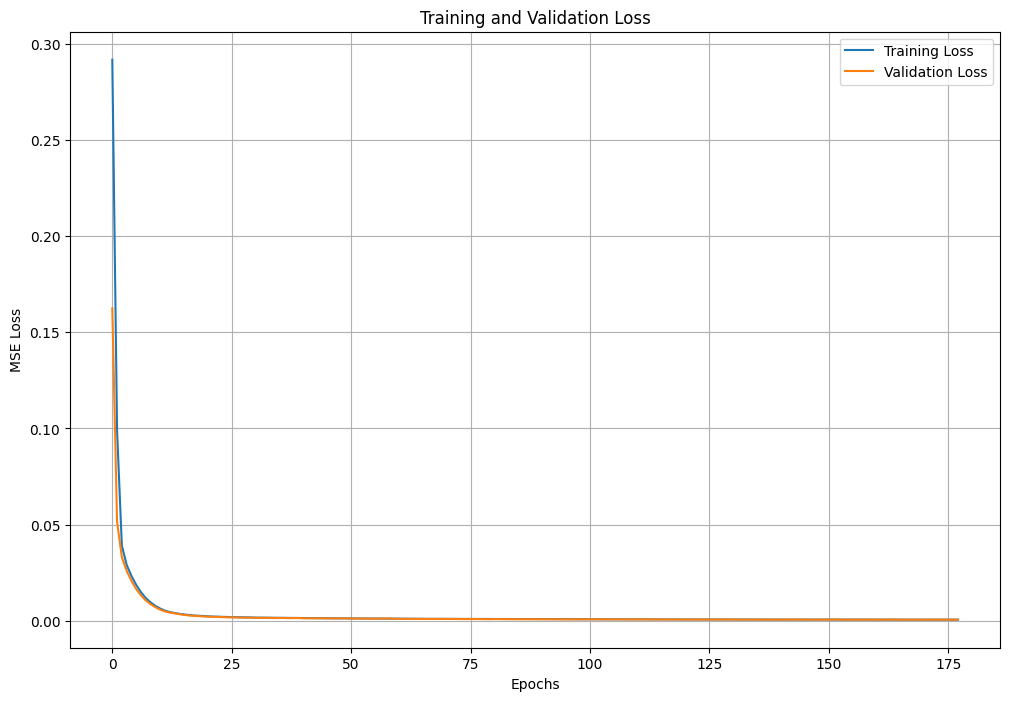

In [43]:
# Plot loss curves for training + validation loss
plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Test MSE Loss: 0.000721
Mean Angular Error: 0.0288 rad (1.65°)


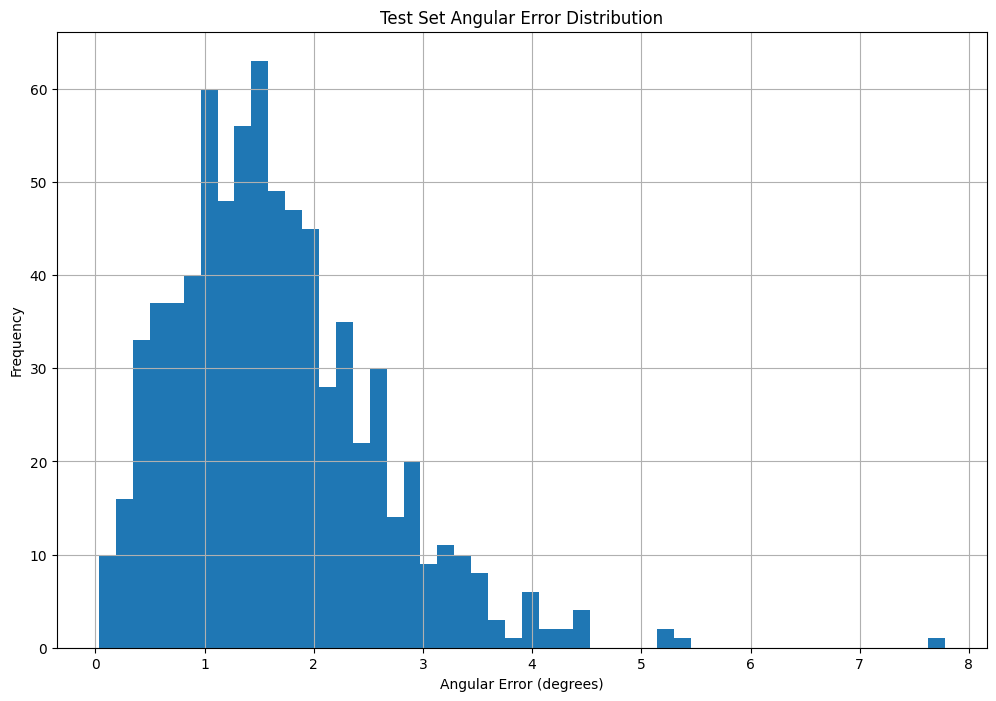

In [44]:
# Test performance
def angular_error(y_pred, y_true):
    """Compute angular error in radians"""
    cos_theta = torch.sum(y_pred * y_true, dim=1) / (
            torch.norm(y_pred, dim=1) * torch.norm(y_true, dim=1)
    )
    cos_theta = torch.clamp(cos_theta, -1.0, 1.0)
    return torch.acos(cos_theta)

model.eval()
test_loss = 0
angular_errors = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        outputs = model(x_test)
        test_loss += criterion(outputs, y_test).item() * x_test.size(0)

        # Project to sphere for angular error calculation
        outputs_normalized = outputs / torch.norm(outputs, dim=1, keepdim=True)
        angular_errors.append(angular_error(outputs_normalized, y_test))

# Calculate metrics
test_loss /= len(test_loader.dataset)
angular_errors = torch.cat(angular_errors)
mean_angular_error = torch.mean(angular_errors).item()
mean_deg_error = np.degrees(mean_angular_error)  # Convert to degrees

print(f'\nTest MSE Loss: {test_loss:.6f}')
print(f'Mean Angular Error: {mean_angular_error:.4f} rad ({mean_deg_error:.2f}°)')

# Plot error distribution
plt.figure(figsize=(12, 8))
plt.hist(np.degrees(angular_errors.numpy()), bins=50)
plt.xlabel('Angular Error (degrees)')
plt.ylabel('Frequency')
plt.title('Test Set Angular Error Distribution')
plt.grid(True)
plt.show()


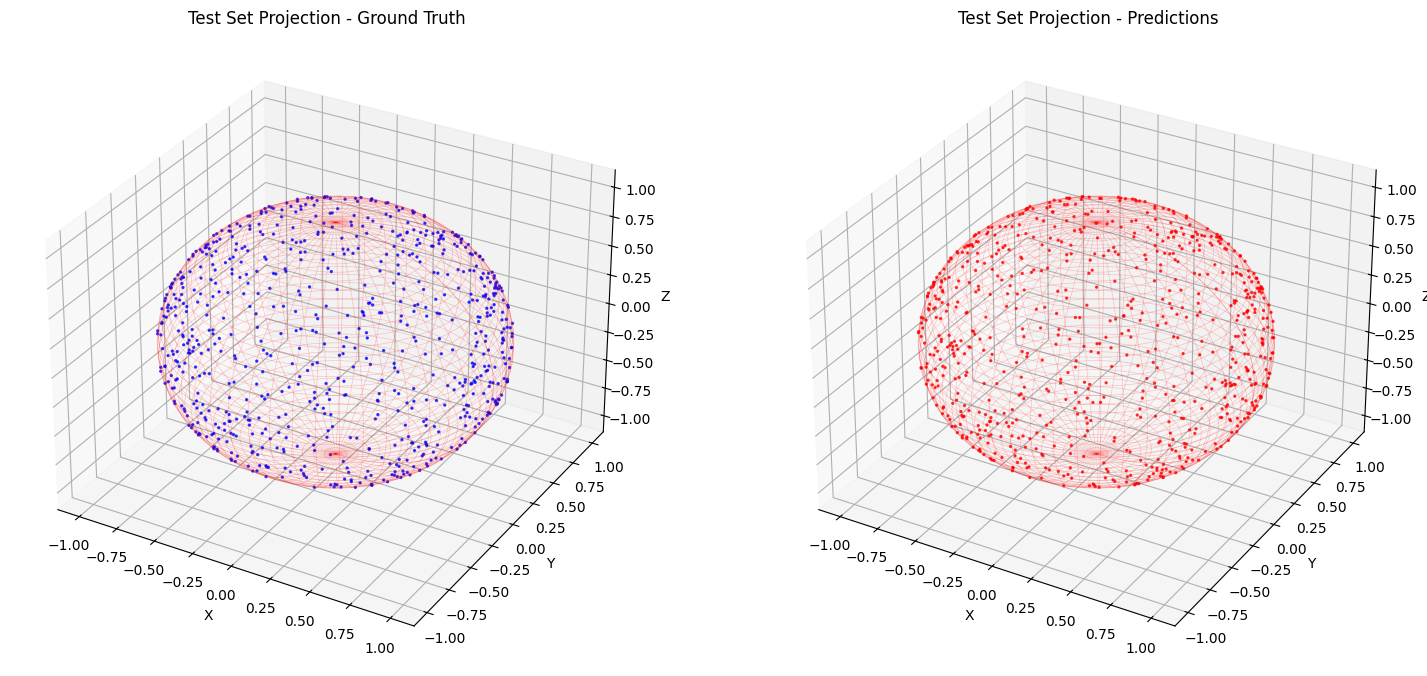

In [45]:
# Training data vs training targets
def plot_comparison(y_true, y_pred, title, unit_sphere=True):
    fig = plt.figure(figsize=(18, 18))

    # Ground Truth
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(y_true[:, 0], y_true[:, 1], y_true[:, 2],
                     c='blue', s=2, alpha=0.7)

    # Add unit sphere if requested
    include_unit_sphere(ax1, unit_sphere=unit_sphere)

    ax1.set_title(f'{title} - Ground Truth')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # Predictions
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2],
                     c='red', s=2, alpha=0.7)

    # Add unit sphere if requested
    include_unit_sphere(ax2, unit_sphere=unit_sphere)

    ax2.set_title(f'{title} - Predictions')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    plt.show()

# Get test samples
x_test_sample = test_data.dataset.tensors[0][test_data.indices]  # Limit display with [:500]
y_true = test_data.dataset.tensors[1][test_data.indices]

# Get predictions
with torch.no_grad():
    raw_preds = model(x_test_sample)
    y_pred = raw_preds / torch.norm(raw_preds, dim=1, keepdim=True)

# Plot comparison
plot_comparison(y_true, y_pred, "Test Set Projection")